In [79]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

In [42]:
mmbrs = pd.read_csv('Sall_members.csv')
mmbrs.head()

,congress,chamber,icpsr,state_icpsr,district_code,state_abbrev,party_code,occupancy,last_means,bioname,...,died,nominate_dim1,nominate_dim2,nominate_log_likelihood,nominate_geo_mean_probability,nominate_number_of_votes,nominate_number_of_errors,conditional,nokken_poole_dim1,nokken_poole_dim2
0,1,President,99869,99,0,USA,5000,NaN,NaN,"WASHINGTON, George",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Senate,2936,1,0,CT,5000,0.0,3.0,"ELLSWORTH, Oliver",...,1807.0,0.530,0.809,-24.37915,0.778,97.0,8.0,NaN,0.528,0.849
2,1,Senate,4998,1,0,CT,5000,0.0,3.0,"JOHNSON, William Samuel",...,1819.0,0.991,0.137,-30.41227,0.690,82.0,16.0,NaN,0.997,0.075
3,1,Senate,507,11,0,DE,4000,0.0,3.0,"BASSETT, Richard",...,1815.0,0.087,0.007,-38.18355,0.654,90.0,23.0,NaN,0.024,0.166
4,1,Senate,7762,11,0,DE,5000,0.0,3.0,"READ, George",...,1798.0,0.282,-0.239,-34.31907,0.699,96.0,15.0,NaN,0.270,-0.206


In [43]:
casts = pd.read_csv('Sall_votes.csv')
casts.head()

,congress,chamber,rollnumber,icpsr,cast_code,prob
0,1,Senate,1,507,1,90.4
1,1,Senate,1,1346,6,48.6
2,1,Senate,1,1536,1,99.8
3,1,Senate,1,2307,1,100.0
4,1,Senate,1,2936,1,99.7


In [44]:
congress = 114

In [45]:
votes = mmbrs[mmbrs['congress'] == congress][mmbrs['chamber'] == 'Senate'][['icpsr','bioname','state_abbrev','party_code']]

def simplify1(x):
    if(x == 200):
        return 'R'
    elif(x == 100):
        return 'D'
    else:
        return 'I'

votes['party_code'] = votes['party_code'].apply(simplify1)
votes.head()

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,icpsr,bioname,party_code
9504,49700,"SESSIONS, Jefferson Beauregard III (Jeff)",R
9505,94659,"SHELBY, Richard C.",R
9506,40300,"MURKOWSKI, Lisa",R
9507,41500,"SULLIVAN, Daniel Scott",R
9508,15039,"McCAIN, John Sidney, III",R


In [46]:
casts = casts[casts['congress'] == congress][['icpsr','rollnumber','cast_code']]

def simplify2(x):
    if(x == 0):
        return None
    elif(x <= 3):
        return 1
    elif(x <= 6):
        return 0
    else:
        return 0.5

casts['cast_code'] = casts['cast_code'].apply(simplify2)
casts.head()

,icpsr,rollnumber,cast_code
4112574,14009,1,0.0
4112575,14226,1,0.0
4112576,14307,1,1.0
4112577,14435,1,1.0
4112578,14440,1,1.0


In [47]:
for i in casts['rollnumber'].drop_duplicates():
    votes = votes.merge(casts[casts['rollnumber'] == i][['icpsr','cast_code']],how='left',on='icpsr')
    votes = votes.rename(columns={'cast_code':'Roll '+str(i)})
votes.head()

,icpsr,bioname,party_code,Roll 1,Roll 2,Roll 3,Roll 4,Roll 5,Roll 6,Roll 7,...,Roll 493,Roll 494,Roll 495,Roll 496,Roll 497,Roll 498,Roll 499,Roll 500,Roll 501,Roll 502
0,49700,"SESSIONS, Jefferson Beauregard III (Jeff)",R,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
1,94659,"SHELBY, Richard C.",R,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2,40300,"MURKOWSKI, Lisa",R,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
3,41500,"SULLIVAN, Daniel Scott",R,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,15039,"McCAIN, John Sidney, III",R,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [48]:
kmeans_model = sklearn.cluster.KMeans(n_clusters=2).fit(votes.iloc[:,3:])
labels = kmeans_model.labels_
print(pd.crosstab(labels,votes['party_code']))

party_code   D  I   R
row_0                
0            0  0  54
1           44  2   0


In [57]:
temp = votes[['party_code']]
temp['labels'] = labels
temp.head()

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,party_code,labels
0,R,0
1,R,0
2,R,0
3,R,0
4,R,0


In [83]:
labels2 = []
labels2.append(temp[temp['labels'] == 0]['party_code'].mode()[0])
labels2.append(temp[temp['labels'] == 1]['party_code'].mode()[0])
labels2

['R', 'D']

In [87]:
labels4 = temp['party_code'].tolist()
for i in range(len(labels2)): 
    if(labels2[i] == 'D'): labels2[i] = 'B'
for i in range(len(labels4)): 
    if(labels4[i] == 'D'): labels4[i] = 'B'
labels3 = pd.Series(labels).apply(lambda x: labels2[x])
sklearn.metrics.accuracy_score(labels4, labels3)

0.98

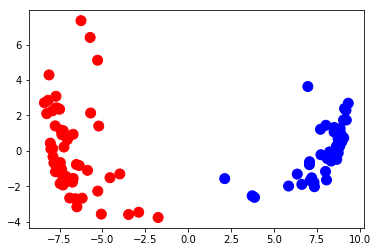

In [78]:
pca_2=sklearn.decomposition.PCA(2)
plot_columns = -pca_2.fit_transform(votes.iloc[:,3:])
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=labels3, s=len(labels))
plt.show()

In [89]:
pca_2.explained_variance_ratio_

array([0.63253017, 0.04861121])

In [88]:
plot_columns[:,0]

array([-7.72661422, -7.70393037, -4.55328873, -7.04127824, -6.70400736,
       -6.70626042, -7.8959225 , -8.24260025,  8.03706762,  7.36774439,
       -6.3482076 ,  7.12004778,  8.72882626,  8.65606428,  7.07654873,
        8.11377318,  7.20856314, -5.68490737, -7.29537188, -7.75132291,
        9.07695301,  8.75676744, -8.1611979 , -8.37931192,  8.84549545,
       -2.88218656, -7.37453255,  3.73785457, -7.45178006, -7.8808859 ,
       -7.73379415, -7.41453487, -5.86823284, -5.71372285, -7.44192048,
       -7.28076987,  6.63483322, -1.74806923,  8.2526808 ,  8.7790266 ,
        9.20773023,  9.34245145,  8.43454044,  8.34220251,  8.01454961,
        8.74714965, -6.485921  , -7.46317014, -7.40749703,  5.86104714,
       -7.49616459,  7.0858208 , -8.00226255, -8.11149304,  7.72179853,
       -5.21351387,  8.07229322, -3.46994772,  8.5139483 ,  9.06571882,
        8.65600653,  8.84429614,  8.93439903,  9.22638381, -6.74449271,
       -7.20197608, -7.11844553,  3.87350538, -5.26845486,  8.86

In [153]:
start = np.min(plot_columns[:,0]); yall = np.zeros(plot_columns.shape[0]); #gap = 2.5
gap = (np.max(plot_columns[:,0]) - np.min(plot_columns[:,0]))/6
while(start <= np.max(plot_columns[:,0])):
    sample = np.where(np.logical_and(start <= plot_columns[:,0], plot_columns[:,0] < start + gap))
    yspace = np.linspace(-10.0, 10.0, num=sample[0].shape[0]+2)
    for i in range(sample[0].shape[0]):
        yall[sample[0][i]] = yspace[i+1] 
    start += gap

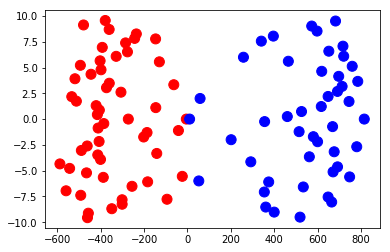

In [220]:
plt.scatter(x=np.power(plot_columns[:,0],3), y=yall, c=labels3, s=len(labels))
plt.show()

In [104]:
np.where(np.logical_and(-7.5 <= plot_columns[:,0], plot_columns[:,0] < -7))[0][1]

18

In [204]:
from bokeh.colors import RGB

def simplify3(x):
    if(x == 'R'):
        return RGB(255,0,0)
    else:
        return RGB(91,155,213)

labels5 = labels3.apply(simplify3)

def simplify4(x):
    if(x == 'R'):
        return RGB(220,0,0)
    else:
        return RGB(47,85,151)

labels6 = labels3.apply(simplify4)

labels5.head()

0    rgb(255, 0, 0)
1    rgb(255, 0, 0)
2    rgb(255, 0, 0)
3    rgb(255, 0, 0)
4    rgb(255, 0, 0)
dtype: object

In [232]:
import math

from bokeh.io import show, output_file, output_notebook
from bokeh.plotting import figure
from bokeh.models import GraphRenderer, StaticLayoutProvider, Circle, MultiLine, HoverTool, TapTool, BoxSelectTool, Slider
from bokeh.palettes import Spectral8

#amp_slider = Slider(start=57, end=115, value=1, step=1,title="Amplitude", callback=callback)


N = np.shape(plot_columns)[0]
issues = votes.shape[1] - 3
node_indices = list(range(N))


x=np.power(plot_columns[:,0],1); y=yall

hover = HoverTool(tooltips=[
    ("Name", "@names"),
    ("State", "@state"),
    ("Party", "@party"),
    ("X-value", "@x_value"),
])

plot = figure(title="Demonstration of Senate Division", x_range=(-11,11), y_range=(-11,11), 
              tools=[hover], toolbar_location=None)

#plot = figure(title="Demonstration of Senate Division", x_range=(np.min(x)*1.1,np.max(x)*1.1), y_range=(-11,11), 
#              tools=[hover], toolbar_location=None)

graph = GraphRenderer()

graph.node_renderer.glyph = Circle(size=15, fill_color="fill_color")
graph.node_renderer.hover_glyph = Circle(size=15, fill_color="hover_color")
graph.node_renderer.data_source.data = dict(
    index=node_indices,
    fill_color=labels5,
    hover_color=labels6,
    names=votes['bioname'],
    party=votes['party_code'],
    #state=votes['state_abbrev'],
    x_value=x)

start1 = []; end1 = []
for i in range(N):
    for j in range(N):
        if(int(np.sum(np.equal(votes.iloc[i:i+1,3:], votes.iloc[j:j+1,3:]),axis=1)) > int(0.5 * issues)):
            start1.append(i)
            end1.append(j)

graph.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_width=1)
graph.edge_renderer.hover_glyph = MultiLine(line_color="#000000", line_width=1)
graph.edge_renderer.data_source.data = dict(start=start1,end=end1)

### start of layout code

graph_layout = dict(zip(node_indices, zip(x, y)))
graph.layout_provider = StaticLayoutProvider(graph_layout=graph_layout)

plot.renderers.append(graph)

output_notebook()
show(plot)

Loading BokehJS ...

E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: fill_color [renderer: GlyphRenderer(id='895461d0-e4e3-41f3-97fa-e606029b8534', ...)]


E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: fill_color [renderer: GlyphRenderer(id='049cd4a3-93ca-43c5-97e5-0fb253cf4af1', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: fill_color [renderer: GlyphRenderer(id='37fc82f4-1a03-4e48-a696-fe7962cb0062', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: fill_color [renderer: GlyphRenderer(id='10a5e186-08ca-4667-afb3-db827a1d0205', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: fill_color [renderer: GlyphRenderer(id='422a0c6d-3cf8-4402-a5c8-c0b9c9edcb27', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: fill_color [renderer: GlyphRenderer(id='af97b69b-7c1b-4db1-adf8-4ea0711c01a9', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: fill_color [renderer: GlyphRenderer(id='8a4620f0-e0ca-4f18-8eae-e020b3ad066f', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: fill_color [renderer:

In [228]:
np.max(x)

9.342451449503171